In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve
)
from sklearn.tree import DecisionTreeClassifier

df = pd.read_csv("/content/customer_churn_dataset-testing-master.csv")
print("Dataset loaded successfully!")
print("\nDataset Shape:", df.shape)
df.head()

print("\nDataset Info:")
print(df.info())
print("\nMissing values:\n", df.isnull().sum())

target_col = 'Churn'

if target_col not in df.columns:
    target_col = df.columns[-1]

X = df.drop(columns=[target_col])
y = df[target_col]

categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(exclude=['object']).columns

print("\nCategorical Columns:", list(categorical_cols))
print("Numerical Columns:", list(numeric_cols))

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("\nTrain/Test Split Done.")
print("Training Size:", X_train.shape)
print("Testing Size:", X_test.shape)


Dataset loaded successfully!

Dataset Shape: (64374, 12)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64374 entries, 0 to 64373
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   CustomerID         64374 non-null  int64 
 1   Age                64374 non-null  int64 
 2   Gender             64374 non-null  object
 3   Tenure             64374 non-null  int64 
 4   Usage Frequency    64374 non-null  int64 
 5   Support Calls      64374 non-null  int64 
 6   Payment Delay      64374 non-null  int64 
 7   Subscription Type  64374 non-null  object
 8   Contract Length    64374 non-null  object
 9   Total Spend        64374 non-null  int64 
 10  Last Interaction   64374 non-null  int64 
 11  Churn              64374 non-null  int64 
dtypes: int64(9), object(3)
memory usage: 5.9+ MB
None

Missing values:
 CustomerID           0
Age                  0
Gender               0
Tenure             

In [12]:
bagging_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', BaggingClassifier(
        estimator=DecisionTreeClassifier(),
        n_estimators=100,
        random_state=42
    ))
])

bagging_clf.fit(X_train, y_train)
y_pred_bag = bagging_clf.predict(X_test)
y_prob_bag = bagging_clf.predict_proba(X_test)[:, 1]

rf_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        random_state=42
    ))
])

rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)
y_prob_rf = rf_clf.predict_proba(X_test)[:, 1]


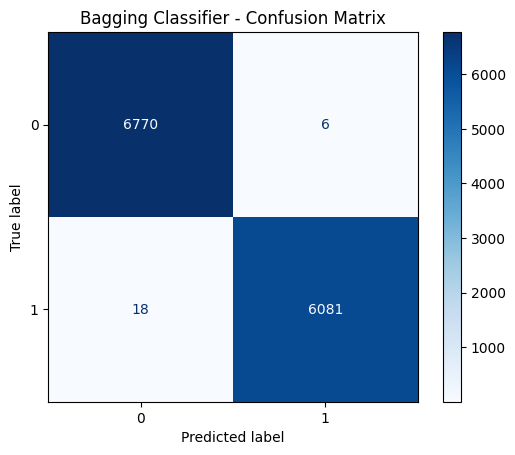

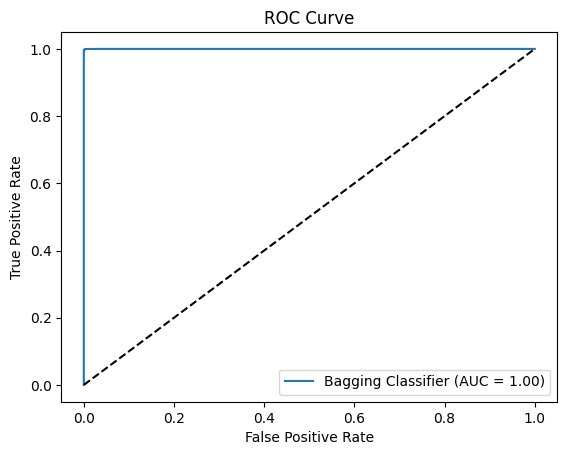

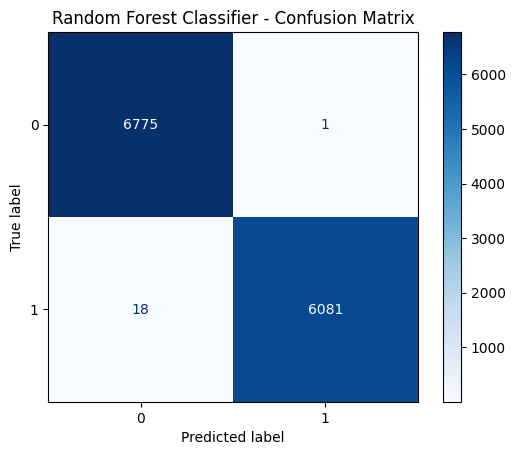

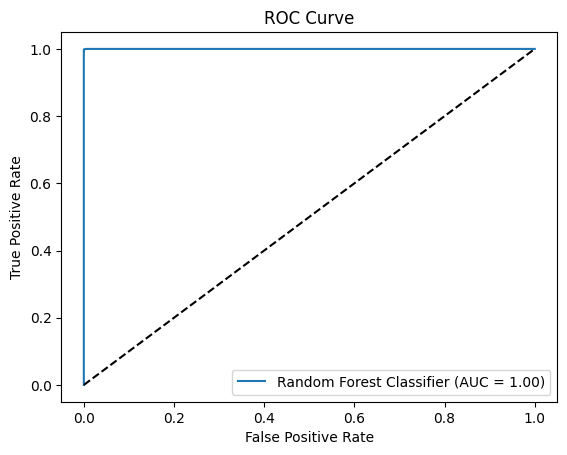


===== MODEL PERFORMANCE COMPARISON =====


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Bagging Classifier,0.998136,0.999014,0.997049,0.998031,0.999989
1,Random Forest Classifier,0.998524,0.999836,0.997049,0.998440,0.999995


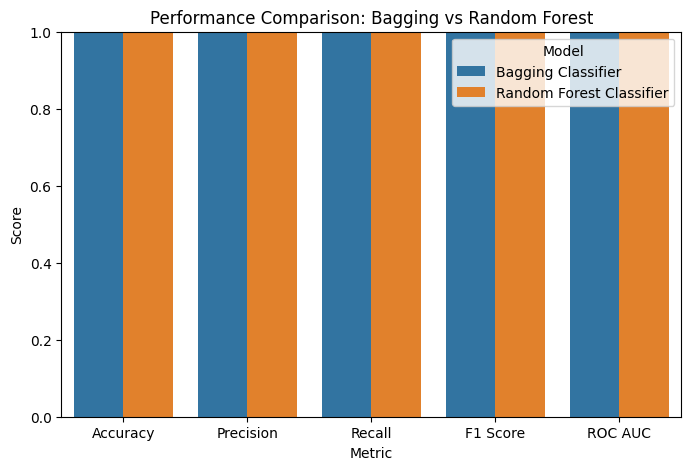

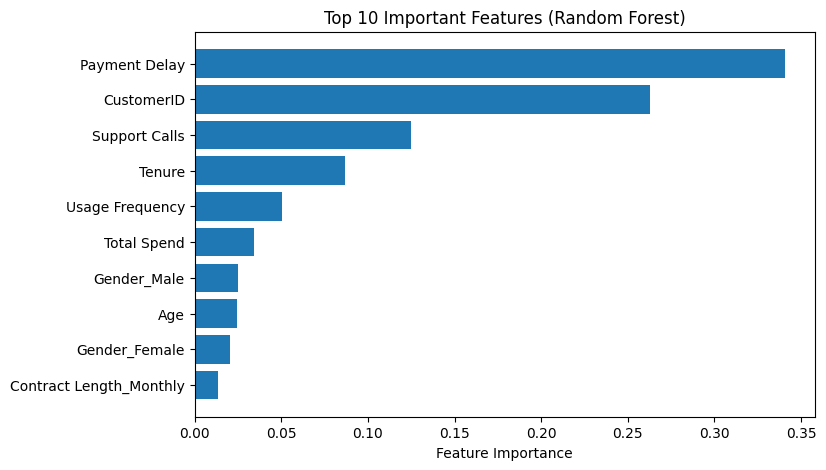

In [15]:
def evaluate_model(y_test, y_pred, y_prob, model_name):
    pos_label = 'Yes' if 'Yes' in y_test.unique() else 1
    roc_y = y_test.map({'No': 0, 'Yes': 1}) if 'Yes' in y_test.unique() else y_test

    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, pos_label=pos_label),
        'Recall': recall_score(y_test, y_pred, pos_label=pos_label),
        'F1 Score': f1_score(y_test, y_pred, pos_label=pos_label),
        'ROC AUC': roc_auc_score(roc_y, y_prob)
    }

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(roc_y, y_prob)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {metrics["ROC AUC"]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

    return metrics

metrics_bagging = evaluate_model(y_test, y_pred_bag, y_prob_bag, "Bagging Classifier")
metrics_rf = evaluate_model(y_test, y_pred_rf, y_prob_rf, "Random Forest Classifier")

comparison_df = pd.DataFrame([metrics_bagging, metrics_rf])
print("\n===== MODEL PERFORMANCE COMPARISON =====")
display(comparison_df)

plt.figure(figsize=(8,5))
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
comparison_melted = comparison_df.melt(id_vars='Model', value_vars=metrics_to_plot)

sns.barplot(data=comparison_melted, x='variable', y='value', hue='Model')
plt.title("Performance Comparison: Bagging vs Random Forest")
plt.ylabel("Score")
plt.xlabel("Metric")
plt.ylim(0, 1)
plt.legend(title="Model")
plt.show()

rf_model = rf_clf.named_steps['classifier']
feature_names = (
    numeric_cols.tolist() +
    list(rf_clf.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_cols))
)

importances = rf_model.feature_importances_
indices = np.argsort(importances)[-10:]

plt.figure(figsize=(8, 5))
plt.barh(np.array(feature_names)[indices], importances[indices])
plt.xlabel("Feature Importance")
plt.title("Top 10 Important Features (Random Forest)")
plt.show()